So right now, my main helper fn is finding all the values and should be plotting them. But the problem is that I need to split each dataset into three ranges with pos, neg, and 0 B-fields. So 24 plots for each dataset. I need to figure out the B-field splitting now and put that into the helper fn somehow. 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [16]:
!cat SHE_Data_Analysis-6.py

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# In[39]:


#Semiconductor Dimensions
width = 10.0/100
length = 10.0/100
thickness = 1.25/1000
cross_area = width * thickness
I = 100e-6
q = 1.602e-19


# ## 2000 G B-field ##

# In[115]:


# Load the 2000G raw data file
df_2000G = pd.read_csv("2000G_100uA.csv", sep="\t", engine="python")

# Convert required columns to numeric
cols_to_convert = ["Temperature (K)", "Voltage AC", "Voltage BD", "B-Field (Gauss)"]
for col in cols_to_convert:
    df_2000G[col] = pd.to_numeric(df_2000G[col], errors="coerce")

# Drop rows with missing values in any of those columns
df_2000G = df_2000G.dropna(subset=cols_to_convert)

# Split the data into three B-field ranges
df2000_B_neg = df_2000G[df_2000G["B-Field (Gauss)"] < -1000].copy()
df2000_B_zero = df_2000G[(df_2000G["B-Field (Gauss)"] >= -1000) & (df_2000G["B-Field (Gauss)"] <= 1000)].copy()
df2000_B_pos = df_2000G[df_2000G["B-F

In [33]:
#Semiconductor Dimensions
width = 10.0/100
length = 10.0/100
thickness = 1.25/1000
cross_area = width * thickness
I = 10e-6
q = 1.602e-19

In [38]:
def analyze_hall_file(file_path, label="", 

    T = "Temperature (K)",
    B_gauss = "B-Field (Gauss)",
    curr_AB = "sample I AB", 
    curr_nAB = "sample I -AB", 
                      
    #longitudinal voltages
    V_DC = "Voltage DC",
    V_nDC = "Voltage -DC",
    
    #transverse voltages
    V_AC = "Voltage AC",
    V_nAC = "Voltage -AC",
    V_BD = "Voltage BD",
    V_nBD = "Voltage -BD",
    assume_whitespace_if_not_csv=True,
    zero_field_gauss=0.0,
    plot=True,
):
    fp = Path(file_path)
    # --- load ---
    if fp.suffix.lower() == ".csv":
        df = pd.read_csv(fp)
    else:
        df = pd.read_csv(fp, sep="\t", engine="python") if assume_whitespace_if_not_csv else pd.read_csv(fp)
    
    # --- numeric conversion ---
    cols_to_convert = [T, B_gauss, curr_AB, curr_nAB, V_DC, V_nDC]
    cols_to_convert += [V_AC, V_nAC]
    for c in cols_to_convert:
        if c not in df.columns:
            raise KeyError(f"Required column missing: {c}")
        df[c] = pd.to_numeric(df[c], errors="coerce")
        
    # --- BD if it exists ---
    has_bd = (V_BD in df.columns) and (V_nBD in df.columns)
    if has_bd:
        df[V_BD] = pd.to_numeric(df[V_BD], errors="coerce")
        df[V_nBD] = pd.to_numeric(df[V_nBD], errors="coerce")
    else:
        print("⚠️ Note: BD pair not found; using AC only for Hall (still OK, just slightly less robust).")

    df = df.dropna(subset=[T, B_gauss, curr_AB, curr_nAB, V_DC, V_nDC, V_AC, V_nAC]).copy()
    df = df.sort_values(T).reset_index(drop=True)
    
    # --- convenience accessors ---
    # Series accessor: keep pandas when you need labels
    def S(name: str) -> pd.Series:
        return df[name]

    # Array accessor: use everywhere for math/plotting to dodge pandas 2.x multi-d indexing issues
    def A(name: str) -> np.ndarray:
        return df[name].to_numpy()

    # Build a one-shot dict of arrays for super quick access (no more .to_numpy() sprinkled)
    arrs = {c: A(c) for c in df.columns}
    
#----------------------------------------------------------------------------------------------------------------#

    df["B"] = df[B_gauss]/1e4
    df["I"] = 0.5*(df[curr_AB].abs() + df[curr_nAB].abs())
    df["inv_T"] = 1.0/df[T]
    
    # --- voltage asymmetries ---
    df["Vxx"] = 0.5*(df[V_DC]+df[V_nDC])
    Vxy_AC = 0.5*(df[V_AC]-df[V_nAC])
    if has_bd:
        Vxy_BD = 0.5*(df[V_BD]-df[V_nBD])
        df["Vxy"] = 0.5*(Vxy_AC + Vxy_BD)
        df["Vxy_AC"] = Vxy_AC
        df["Vxy_BD"] = Vxy_BD
    else:
        df["Vxy"] = Vxy_AC
        df["Vxy_AC"] = Vxy_AC
    
    # --- resistances ---
    df["Rxx"] = df["Vxx"]/df["I"]
    df["Rxy"] = df["Vxy"]/df["I"]
    df["rhoxx"] = df["Rxx"] * (cross_area / length)
    df["rhoxy"] = df["Rxy"] * thickness
    df["sigma"] = 1.0/df["rhoxx"]
    
    # --- hall coefficient ---
    with np.errstate(divide="ignore", invalid="ignore"):
        df["hall_coeff"] = df["rhoxy"]/df["B"]
        df["n"] = 1.0/(q*df["hall_coeff"])
        df["mu"] = df["sigma"]*df["hall_coeff"]
        df["hallxsigma"] = df["hall_coeff"]*df["sigma"]
    
    # --- MR relative to B=0 (if B=0 rows exist in same file) ---
    df0 = df[np.isclose(df[B_gauss], zero_field_gauss, atol=1e-6)]
    rho0 = np.nan
    if not df0.empty:
        rho0 = float(df0["rhoxx"].median())
        df["MR_fraction"] = (df["rhoxx"] - rho0) / rho0
        
    # --- room temp ---
    def nmean(s):
        s=s.dropna()
        return float(s.mean()) if len(s) else np.nan
    
    rt = df[(df[T] >= 295) & (df[T] <= 305)]
    rt_summary = {
        "label": label or fp.name,
        "T_mean": nmean(rt[T]),
        "B_mean": nmean(rt["B"]),
        "rhoxx": nmean(rt["rhoxx"]),
        "sigma": nmean(rt["sigma"]),
        "hall_coeff": nmean(rt["hall_coeff"]),
        "n": nmean(rt["n"]),
        "mu": nmean(rt["mu"]),
        "B_eq": (nmean(rt["rhoxx"]) / nmean(rt["hall_coeff"])) if np.isfinite(nmean(rt["hall_coeff"])) and nmean(rt["hall_coeff"]) != 0 else np.nan,
        "rho0_for_MR": rho0,
    }
        
    # --- plots ---
    if plot:
        # ρ vs 1/T
        plt.figure()
        plt.plot(A("inv_T"), A("rhoxx"))
        plt.xlabel("1 / T (1/K)"); plt.ylabel("Resistivity ρ (Ω·m)")
        plt.title(f"ρ vs 1/T — {label or fp.name}"); plt.gca().invert_xaxis(); plt.show()

        # σ vs 1/T
        plt.figure()
        plt.plot(A("inv_T"), A("sigma"))
        plt.xlabel("1 / T (1/K)"); plt.ylabel("Conductivity σ (S/m)")
        plt.title(f"σ vs 1/T — {label or fp.name}"); plt.gca().invert_xaxis(); plt.show()

        # R_H vs 1/T
        plt.figure()
        plt.plot(A("inv_T"), A("hall_coeff"))
        plt.xlabel("1 / T (1/K)"); plt.ylabel("Hall Coefficient R_H (m³/C)")
        plt.title(f"R_H vs 1/T — {label or fp.name}"); plt.gca().invert_xaxis(); plt.show()

        # μ vs T
        plt.figure()
        plt.plot(A(T), A("mu"))
        plt.xlabel("Temperature (K)"); plt.ylabel("Mobility μ (m²/V·s)")
        plt.title(f"Mobility vs T — {label or fp.name}"); plt.show()

        # n vs T
        plt.figure()
        plt.plot(A(T), A("n"))
        plt.xlabel("Temperature (K)"); plt.ylabel("Carrier concentration n (m⁻³)")
        plt.title(f"Carrier concentration vs T — {label or fp.name}"); plt.show()

        # (R_H * σ) vs T
        plt.figure()
        plt.plot(A(T), A("hallxsigma"))
        plt.xlabel("Temperature (K)"); plt.ylabel("R_H × σ")
        plt.title(f"(Hall coefficient × Conductivity) vs T — {label or fp.name}"); plt.show()

        # Hall antisym voltage vs B (linearity/sign check)
        plt.figure()
        plt.plot(A("B"), A("Vxy"), ".")
        plt.xlabel("B (T)"); plt.ylabel("Hall (antisym) V (V)")
        plt.title(f"Hall antisymmetric V vs B — {label or fp.name}"); plt.show()

        # MR vs T if zero-field present
        if "MR_fraction" in df:
            plt.figure()
            plt.plot(df[col_T], 100*df["MR_fraction"])
            plt.xlabel("Temperature (K)"); plt.ylabel("MR (%)")
            plt.title(f"Magnetoresistance vs T (ref = B=0) — {label or fp.name}")
            plt.show()

    return df, rt_summary

In [39]:
def split_by_gauss(df, B_gauss="B-Field (Gauss)", Tcol="Temperature (K)", thr=1000.0):
    neg  = df[df[B_gauss] <  -thr].copy()
    zero = df[(df[B_gauss] >= -thr) & (df[B_gauss] <= thr)].copy()
    pos  = df[df[B_gauss] >   thr].copy()

    # keep the same helper columns you made before
    for d in (neg, zero, pos):
        d["1/T (1/K)"] = 1.0 / pd.to_numeric(d[Tcol])
        d["B (T)"]     = d[B_gauss] / 1e4
    return neg, zero, pos

In [40]:
df_2000G, rt_2000G = analyze_hall_file("2000G10uA.txt", plot=False)
neg, zero, pos = split_by_gauss(df_2000G, B_gauss="B-Field (Gauss)", Tcol="Temperature (K)", thr=1000.0)

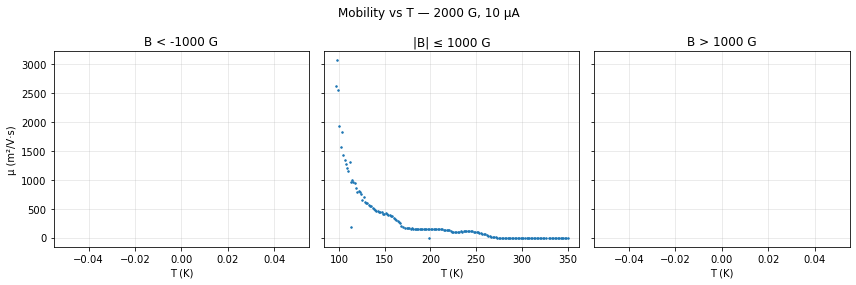

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
for ax, d, title in [
    (axes[0], neg,  "B < -1000 G"),
    (axes[1], zero, "|B| ≤ 1000 G"),
    (axes[2], pos,  "B > 1000 G"),
]:
    ax.plot(d["Temperature (K)"].to_numpy(), d["mu"].to_numpy(), ".", ms=3)
    ax.set_title(title); ax.set_xlabel("T (K)"); ax.grid(True, alpha=0.3)
axes[0].set_ylabel("μ (m²/V·s)")
fig.suptitle("Mobility vs T — 2000 G, 10 µA"); fig.tight_layout(); plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def split_masks_by_gauss(df, B_gauss="B-Field (Gauss)", thr=1000.0):
    """Return numpy masks for B<−thr, |B|≤thr, B>thr (Gauss threshold)."""
    Bg = df[B_gauss].to_numpy()
    mask_neg  = Bg <  -thr
    mask_zero = (Bg >= -thr) & (Bg <= thr)
    mask_pos  = Bg >   thr
    return mask_neg, mask_zero, mask_pos, thr

def plot_triptych_grid(
    df, *,
    label="",
    B_gauss="B-Field (Gauss)",
    Tcol="Temperature (K)",
    thr=1000.0,
    specs=None,      # list of (xcol, ycol, xlabel, ylabel, invert_x, nz_only, scale)
    point_size=2
):
    """
    Make a grid with 3 cols = {B<−thr, |B|≤thr, B>thr} and one row per 'spec'.
    - nz_only=True will suppress the center panel (zero-B) for Hall-only metrics.
    - scale (float) multiplies y values (e.g., 100 for MR → %).
    """
    # default set (8 rows). Tcol can be a variable string like "Temperature (K)"
    if specs is None:
        specs = [
            ("inv_T",      "rhoxx",       "1 / T (1/K)",    "ρ (Ω·m)",            True,  False, 1.0),
            ("inv_T",      "sigma",       "1 / T (1/K)",    "σ (S/m)",            True,  False, 1.0),
            ("inv_T",      "hall_coeff",  "1 / T (1/K)",    "R_H (m³/C)",         True,  True,  1.0),
            (Tcol,         "mu",          "T (K)",          "μ (m²/V·s)",         False, True,  1.0),
            (Tcol,         "n",           "T (K)",          "n (m⁻³)",            False, True,  1.0),
            (Tcol,         "hallxsigma",  "T (K)",          "R_H × σ",            False, True,  1.0),
            ("B",          "Vxy",         "B (T)",          "Vxy (V)",            False, False, 1.0),
            (Tcol,         "MR_fraction", "T (K)",          "MR (%)",             False, False, 100.0),  # ×100 → %
        ]

    mask_neg, mask_zero, mask_pos, thr = split_masks_by_gauss(df, B_gauss=B_gauss, thr=thr)
    masks = [mask_neg, mask_zero, mask_pos]
    titles = [f"B < -{thr:.0f} G", f"|B| ≤ {thr:.0f} G", f"B > {thr:.0f} G"]

    nrows = len(specs)
    fig, axes = plt.subplots(nrows, 3, figsize=(13.5, 3.0*nrows), sharey=False, squeeze=False)

    # small accessor that returns numpy arrays
    arr = lambda c: df[c].to_numpy() if c in df.columns else None

    for r, (xcol, ycol, xlabel, ylabel, invert_x, nz_only, scale) in enumerate(specs):
        x = arr(xcol); y = arr(ycol)
        for c in range(3):
            ax = axes[r, c]
            ax.grid(True, alpha=0.25)
            ax.set_xlabel(xlabel)
            if c == 0:  # only first col shows y label
                ax.set_ylabel(ylabel)

            # missing column? write a gentle note and continue
            if x is None or y is None:
                ax.text(0.5, 0.5, f"Missing: {xcol if x is None else ycol}", ha="center", va="center")
                continue

            m = masks[c].copy()
            # If this is a “nonzero-B-only” metric, blank out the center panel
            if nz_only and c == 1:  # center is zero-B
                m &= False

            mm = m & np.isfinite(x) & np.isfinite(y)
            if not np.any(mm):
                ax.set_title(titles[c] + " (no points)")
                continue

            yplot = y[mm] * float(scale)
            ax.plot(x[mm], yplot, ".", ms=point_size)
            ax.set_title(f"{titles[c]}  (n={int(mm.sum())})")
            if invert_x:
                ax.invert_xaxis()

    if label:
        fig.suptitle(label, y=0.995)
    fig.tight_layout(rect=(0,0,1,0.98))
    return axes


In [ ]:
# 2000 G, 10 µA (TXT)
df_2000G, rt_2000G = analyze_hall_file(
    "2000G10uA.txt",
    label="2000 G, 10 µA",
    assume_whitespace_if_not_csv=True,
    plot=False,   # <- turn off per-file plotting
)
# (optional) if you know the excitation current exactly for this file:
# df_2000G["I"] = 10e-6

plot_triptych_grid(
    df_2000G,
    label="2000 G, 10 µA",
    B_gauss="B-Field (Gauss)",
    Tcol="Temperature (K)",
    thr=1000.0,   # same threshold you used before
)

# 1000 G, 100 µA (CSV)
df_1000G, rt_1000G = analyze_hall_file(
    "/mnt/data/1000G_100uA.csv",
    label="1000 G, 100 µA",
    plot=False,
)
# df_1000G["I"] = 100e-6   # if you want to force fixed current
plot_triptych_grid(df_1000G, label="1000 G, 100 µA",
                   B_gauss="B-Field (Gauss)", Tcol="Temperature (K)", thr=1000.0)

# 2000 G, 100 µA (CSV)
df_2000G_100, rt_2000G_100 = analyze_hall_file(
    "/mnt/data/2000G_100uA.csv",
    label="2000 G, 100 µA",
    plot=False,
)
# df_2000G_100["I"] = 100e-6
plot_triptych_grid(df_2000G_100, label="2000 G, 100 µA",
                   B_gauss="B-Field (Gauss)", Tcol="Temperature (K)", thr=1000.0)
